# Stratifying an SIR model by risk group using AlgebraicPetri.jl

Simon Frost (@sdwfrost), 2023-06-13

## Introduction

This example serves as a ‘Hello World’ to stratifying Petri net models,
where a coarse model is stratified by another model - in this case, two
risk groups, `H` and `L`, with high and low contact rates respectively.

## Libraries

In [1]:
using AlgebraicPetri,AlgebraicPetri.TypedPetri
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs
using Catlab.WiringDiagrams, Catlab.Graphics
using AlgebraicDynamics.UWDDynam
using OrdinaryDiffEq
using LabelledArrays
using Plots

## Transitions

We first define a labelled Petri net that has the different types of
transition in our models. The first argument is an array of state names
as symbols (here, a generic `:Pop`), followed by the transitions in the
model. Transitions are given as
`transition_name=>((input_states)=>(output_states))`. In this model, we
consider the groups as fixed (i.e. no changes between strata), so we
just need to have infection and recovery in the model.

In [2]:
epi_transitions = LabelledPetriNet(
  [:Pop],
  :infection=>((:Pop, :Pop)=>(:Pop, :Pop)),
  :recovery=>(:Pop=>:Pop)
)
Graph(epi_transitions)

We create a labelled Petri net of the SIR model using the above
transitions (or alternatively, we could compose from infection and
recovery submodels).

In [3]:
sir_uwd = @relation () where (S::Pop, I::Pop, R::Pop) begin
    infection(S, I, I, I)
    recovery(I, R)
end
sir_acst = oapply_typed(epi_transitions, sir_uwd, [:β , :γ])
sir_lpn = dom(sir_acst)
Graph(sir_lpn)

We then define a second model with two groups with different contact
rates. This also has infection and recovery terms defined in terms of
within- and between-group interactions.

In [4]:
risk_uwd = @relation () where (H::Pop, L::Pop) begin
    infection(H,H,H,H) # Within H infection
    infection(H,L,H,L) # Infection of S_H by I_L
    infection(L,H,L,H) # Infection of S_L by I_H
    infection(L,L,L,L) # Within L infection
    recovery(H,H) # H recovery
    recovery(L,L) # L recovery
end
risk_acst = oapply_typed(epi_transitions, risk_uwd, [:HH, :HL, :LH, :LL, :H, :L])
risk_lpn = dom(risk_acst)
Graph(risk_lpn)

We create a stratified model by using a typed product between the SIR
model and the risk model, to generate an `ACSetTransformation`, from
which we subsequently extract a labelled Petri net.

In [5]:
sir_risk_acst = typed_product(sir_acst, risk_acst)
sir_risk_lpn = dom(sir_risk_acst)
Graph(sir_risk_lpn)

The state names of the resulting stratified model are tuples of symbols:

In [6]:
snames(sir_risk_lpn)

6-element Vector{Tuple{Symbol, Symbol}}:
 (:S, :H)
 (:I, :H)
 (:R, :H)
 (:S, :L)
 (:I, :L)
 (:R, :L)

The solvers in `OrdinaryDiffEq.jl` do not work with these state names,
so we use `flatten_labels` to obtain a vector of symbols (of the form
`:S_H`, `:I_H`, etc.).

In [7]:
sir_risk_lpn_flatlabels = flatten_labels(sir_risk_lpn)
Graph(sir_risk_lpn_flatlabels)

## Running the model

To run the model, we need to choose specific group sizes and parameter
values. We define two groups of equal size and initial composition.

In [8]:
K = 2
S = [495.0, 495.0]
I = [5.0, 5.0]
R = [0.0, 0.0]
N = [S[i]+I[i]+R[i] for i in 1:K]

2-element Vector{Float64}:
 500.0
 500.0

The model above is defined in terms of transmission rates between the
two groups, which is a combination of (a) the contact rates between the
two groups and (b) the probability of transmission per infectious
contact. We assume that the two groups have different overall contact
rates, `c`, and that the fraction of contacts between groups `i` and
`j`, `pij`, follows a proportional mixing assumption.

In [9]:
β = 0.05
c = [20.0, 5.0]
pij = hcat([[c[j]*N[j]/sum([c[k]*N[k] for k in 1:K]) for j in 1:K] for i in 1:K]...)'
betas = (β .* (c .* pij) ./ N)
γ = 0.25;

We now define the initial conditions and parameter arrays as labelled
arrays.

In [10]:
u0 = @LArray vec([S I R]')[:,1] Tuple(snames(sir_risk_lpn_flatlabels))
p = @LArray [vec(betas); γ; γ] Tuple(tnames(sir_risk_lpn_flatlabels))
tspan = (0.0, 40.0);

We then compute the vector field from the labelled Petri net (with
flatten labels), define the `ODEProblem`, and solve.

In [11]:
sir_risk_vf = vectorfield(sir_risk_lpn_flatlabels)
sir_risk_prob = ODEProblem(sir_risk_vf, u0, tspan, p)
sir_risk_sol = solve(sir_risk_prob, Rosenbrock32());

## Plotting


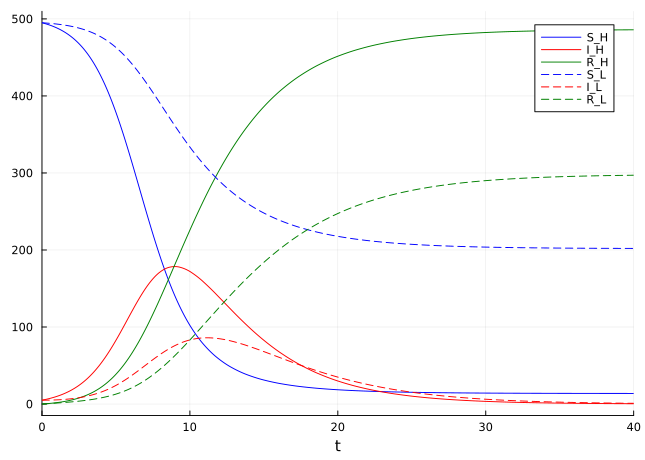

In [12]:
plot(sir_risk_sol, linecolor=[:blue :red :green], linestyle=[:solid :solid :solid :dash :dash :dash])